# Objective: Match Kravtsov's BCGs to objects in RedMaPPer

* Kravtsov (2014) considers a sample of nine Brightest Cluster Galaxies, comparing their stellar mass estimates with those of Bernardi et al.


* In this notebook, we first use the `astropy` function `match_catalog_to_sky` to find the overlap between Kravtsov's BCGs and our `RedMaPPer` sample. The RA/Dec of the sources from Kravtsov were hand-picked from SDSS DR13. Our finalized coordinates are available on our GutHub in an `ecsv` file.

    * [SDSS DR13](http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx)
    * [Finalized Coordinates](https://github.com/moustakas/siena-astrophysics/blob/masscompare/research/massivepilot/kravsources.ecsv)


* We then compare the stellar masses (M*) of the matching sources.

In [31]:
import os

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
from astropy.io.ascii import read
from astropy.coordinates import SkyCoord
from astropy import units as u
import fitsio
import seaborn

## Reading in all necessary data and making initial cuts.

In [16]:
# Setting convenient paths.
pypath = os.path.join(os.sep, 'global', 'work', 'projects', 'legacysurvey', 'legacycentrals')
meertcat = os.path.join(pypath, 'meert_et_al_data_tables_v2')
mendelcat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
wisccat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlPCAWiscM11.dat')

In [17]:
# Read the Mendel catalog
columns = ('GalCount', 'FlagSerExp', 'Mstar_Tab5_Pymorph',
           'Mstar_Tab5_Truncated', 'Mstar_Tab3_Pymorph',
           'Mstar_Tab3_Truncated', 'Mstar_Tab5_Mendel',
           'Mstar_Tab3_Mendel', 'Mstar_Tab5_cModel',
           'Mstar_Tab3_cModel')
dtype = np.dtype([(col, np.float) for col in columns])
allmendel = np.loadtxt(mendelcat, dtype=dtype)

In [19]:
# Trim the Mendel catalog. Here we simply remove the bad flags.
keep = (np.where(allmendel['FlagSerExp'] == 0))[0]
print('Keeping {} / {} measurements in the Mendel catalog.'.format(len(keep), len(allmendel)))
mendel = allmendel[keep]

Keeping 628919 / 670722 measurements in the Mendel catalog.


In [20]:
# Read the parent Meert catalog to get ra, dec and other info.
upennpath = os.path.join(pypath, 'meert_et_al_data_tables_v2')
upenncatfile = os.path.join(upennpath, 'UPenn_PhotDec_CAST.fits')
upenncat = fitsio.read(upenncatfile, ext=1, rows=keep, upper=True)

In [21]:
# Reading in all the RedMaPPer iSEDfit catalog.
rmpath = os.path.join(os.sep, 'global', 'work', 'projects', 'redmapper')
rmcatfile = os.path.join(rmpath, 'redmapper_isedfit_v5.10_centrals.fits.gz')
rminfo = fitsio.FITS(rmcatfile)
rmcat = rminfo[1].read(columns=['Z', 'RA', 'DEC', 'MSTAR_50', 'MSTAR_AVG', 'MSTAR_ERR'])

In [22]:
# Reading in the RA, Dec, and helioZ of Kravtsov's selected objects.
kravsources = os.path.join(os.sep, 'home','kjnapes', 'siena-astrophysics', 'research', 'massivepilot',
                           'kravsources.txt')
sourceRA, sourceDEC, helioZ = np.loadtxt(kravsources, unpack=True, usecols=(1,2,3))
name = np.genfromtxt(kravsources, dtype='U', usecols=0)

## Matching RedMaPPer and Kravtsov

In [42]:
# Cross-matching catalogs
rcoord = SkyCoord(ra=rmcat['RA']*u.degree, dec=rmcat['DEC']*u.degree)
kravcoord = SkyCoord(ra=sourceRA*u.degree, dec=sourceDEC*u.degree)
idx, sep2d, dist3d = kravcoord.match_to_catalog_sky(rcoord, nthneighbor=1)

# Applying a limiting tolerance to matches. 30 arcseconds is a reasonable radius.
gd = np.where(sep2d < 30 * u.arcsec)[0]

In [43]:
# Looking at the indices and properties of the matches. 
print(gd)
print(name[gd])
print(rmcat['RA'][idx[gd]])
print(rmcat['DEC'][idx[gd]])
print(rmcat['Z'][idx[gd]]) # The redshifts are a little off...
print(rmcat['MSTAR_50'][idx[gd]])
print(rmcat['MSTAR_AVG'][idx[gd]])
print(rmcat['MSTAR_ERR'][idx[gd]])

[0 4 5]
["'A2142'" "'MKW3s'" "'A2052'"]
[ 239.58332907  230.46604816  229.18537268]
[ 27.23341292   7.70881574   7.02162407]
[ 0.09577668  0.06400454  0.05806554]
[ 12.03588104  12.04784679  10.70101738]
[ 12.00933456  12.06140423  10.70101643]
[ 0.06717658  0.02627182  0.        ]


## Matching PyMorph and Kravtsov

In [44]:
# Cross-matching catalogs
rcoord = SkyCoord(ra=upenncat['RA']*u.degree, dec=upenncat['DEC']*u.degree)
kravcoord = SkyCoord(ra=sourceRA*u.degree, dec=sourceDEC*u.degree)
idx, sep2d, dist3d = kravcoord.match_to_catalog_sky(rcoord, nthneighbor=1)

# Applying a limiting tolerance to matches
gdpy = np.where(sep2d < 30 * u.arcsec)[0]
print(len(gdpy))

3


In [45]:
print(name[gdpy])
print(upenncat['RA'][idx[gdpy]])
print(upenncat['DEC'][idx[gdpy]])

["'A2142'" "'A1991'" "'RXJ1159'"]
[ 239.58299255  223.63999939  179.96699524]
[ 27.23340034  18.63890076  55.53490067]


# Looking at the overlap between the catalogs.

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


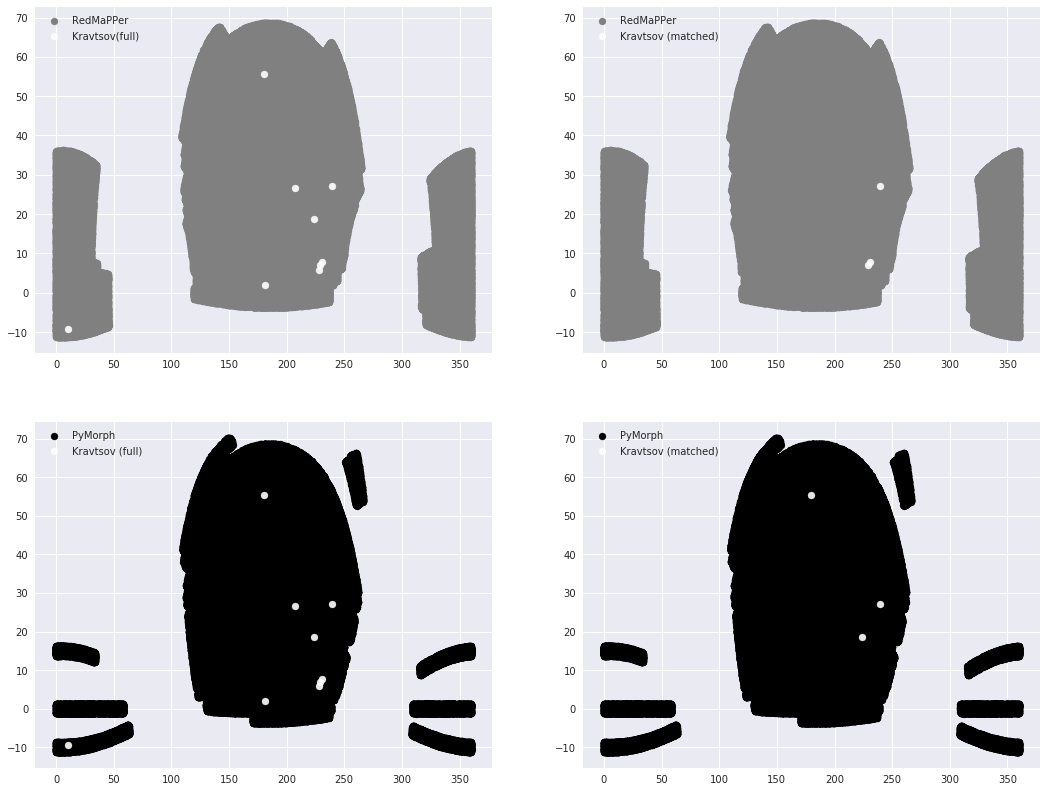

In [51]:
fig = plt.figure(figsize(18,14))

ax2 = fig.add_subplot(221)
ax2.scatter(rmcat['RA'], rmcat['DEC'], color='gray', label='RedMaPPer')
ax2.scatter(sourceRA, sourceDEC, alpha=0.9, color='white', label='Kravtsov(full)')
ax2.legend(loc='upper left')

ax1 = fig.add_subplot(222)
ax1.scatter(rmcat['RA'], rmcat['DEC'], color='gray', label='RedMaPPer')
ax1.scatter(sourceRA[gd], sourceDEC[gd], alpha=0.9, color='white', label='Kravtsov (matched)')
ax1.legend(loc='upper left')

ax3 = fig.add_subplot(223)
ax3.scatter(upenncat['RA'], upenncat['DEC'], color='black', label='PyMorph')
ax3.scatter(sourceRA, sourceDEC, alpha=0.9, color='white', label='Kravtsov (full)')
ax3.legend(loc='upper left')

ax4 = fig.add_subplot(224)
ax4.scatter(upenncat['RA'], upenncat['DEC'], color='black', label='PyMorph')
ax4.scatter(sourceRA[gdpy], sourceDEC[gdpy], alpha=0.9, color='white', label='Kravtsov (matched)')
ax4.legend(loc='upper left')